<a href="https://colab.research.google.com/github/indhu68/Intro_to_ML_HW7/blob/main/HW7_Q1_IntroToML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Introduction to Machine Learning
                              Homework 7

Name : Indhuja Gudluru

Student ID : 801366046


In [1]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
time: 341 µs (started: 2023-12-13 19:05:38 +00:00)


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)


time: 10 s (started: 2023-12-13 19:05:41 +00:00)


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

time: 55.1 ms (started: 2023-12-13 19:06:18 +00:00)


In [4]:

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculating mean and standard(std)
images = torch.stack([img_t for img_t, _ in training_dataset], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:03<00:00, 49409254.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 17.3 s (started: 2023-12-13 19:06:20 +00:00)


In [5]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 28.6 ms (started: 2023-12-13 19:06:39 +00:00)


In [6]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 4.53 ms (started: 2023-12-13 19:06:41 +00:00)


In [7]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 542 ms (started: 2023-12-13 19:06:43 +00:00)


In [8]:
cifar10_testing = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 795 ms (started: 2023-12-13 19:06:46 +00:00)


In [9]:

image1, label = cifar10[0]
print(image1.shape)

torch.Size([3, 32, 32])
time: 8.36 ms (started: 2023-12-13 19:06:50 +00:00)


In [10]:
training_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
testing_loader = DataLoader(cifar10_testing, batch_size=32, shuffle=False, num_workers=2)

time: 1 ms (started: 2023-12-13 19:06:51 +00:00)


In [11]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 674 µs (started: 2023-12-13 19:06:53 +00:00)


In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

time: 1.12 ms (started: 2023-12-13 19:06:55 +00:00)


In [13]:

model = Net().to(device)

time: 6.83 s (started: 2023-12-13 19:06:57 +00:00)


In [14]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 3.42 ms (started: 2023-12-13 19:07:07 +00:00)


In [15]:
import datetime

def training_loop(epochs, optimizer, model, loss_function, training_loader):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        for images, labels in training_loader:
            images = images.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, training_loss/ len(training_loader)))

time: 1 ms (started: 2023-12-13 19:07:10 +00:00)


In [16]:
training_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_function = loss_function,
    training_loader = training_loader,
)


2023-12-13 19:07:33.436784 Epoch 1, Training loss 2.0680620380679664
2023-12-13 19:07:47.345345 Epoch 2, Training loss 1.797558703843285
2023-12-13 19:08:15.200669 Epoch 4, Training loss 1.5253492827000825
2023-12-13 19:08:43.465319 Epoch 6, Training loss 1.381527537732478
2023-12-13 19:09:10.672849 Epoch 8, Training loss 1.2716999192676885
2023-12-13 19:09:38.119350 Epoch 10, Training loss 1.1939342052430448
2023-12-13 19:10:06.361270 Epoch 12, Training loss 1.136126101093219
2023-12-13 19:10:35.538602 Epoch 14, Training loss 1.0900061940750503
2023-12-13 19:11:04.351722 Epoch 16, Training loss 1.0553208796112128
2023-12-13 19:11:34.177920 Epoch 18, Training loss 1.022562860375475
2023-12-13 19:12:02.367211 Epoch 20, Training loss 0.9952505692801512
2023-12-13 19:12:31.271442 Epoch 22, Training loss 0.9690781202157746
2023-12-13 19:13:00.760146 Epoch 24, Training loss 0.9482919117221442
2023-12-13 19:13:29.203898 Epoch 26, Training loss 0.9290986607599137
2023-12-13 19:13:56.620266 Ep

In [17]:
import collections
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_testing, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    acc_dict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        acc_dict[name] = correct / total
    return acc_dict, predictions, exp_labels

time: 4.52 ms (started: 2023-12-13 20:22:50 +00:00)


In [18]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 0.79
Accuracy val: 0.61
time: 15.8 s (started: 2023-12-13 20:23:01 +00:00)


In [19]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.77      0.83      0.80      5569
  automobile       0.89      0.88      0.89      6044
        bird       0.67      0.69      0.68      5792
         cat       0.58      0.64      0.61      5458
        deer       0.68      0.71      0.70      5680
         dog       0.66      0.74      0.70      5355
        frog       0.93      0.60      0.73      9263
       horse       0.71      0.90      0.79      4771
        ship       0.88      0.82      0.85      6418
       truck       0.83      0.88      0.85      5650

    accuracy                           0.76     60000
   macro avg       0.76      0.77      0.76     60000
weighted avg       0.77      0.76      0.76     60000

time: 203 ms (started: 2023-12-13 20:23:34 +00:00)


In [20]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)

time: 402 ms (started: 2023-12-13 20:23:48 +00:00)


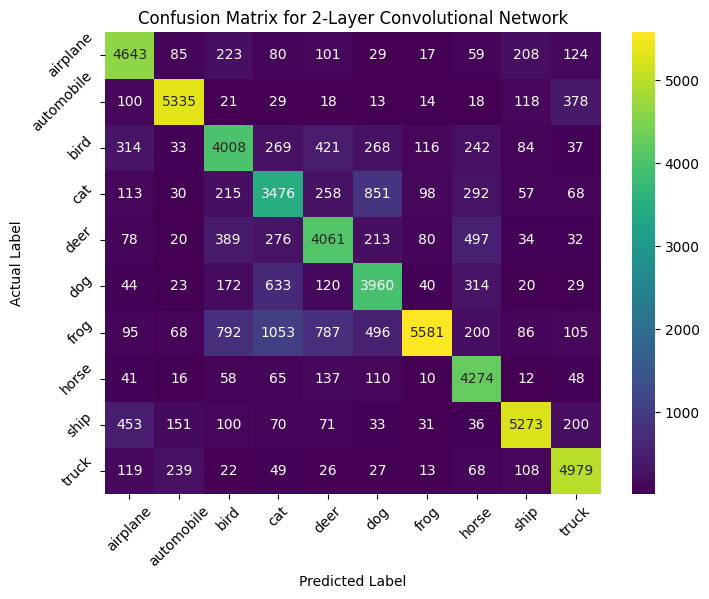

time: 486 ms (started: 2023-12-13 20:24:43 +00:00)


In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix for 2-Layer Convolutional Network')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

Problem:1)b)

In [23]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 4, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = out.view(-1, 4 * 4 * 4)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

time: 4.61 ms (started: 2023-12-13 20:25:08 +00:00)


In [24]:
model2 = Net2().to(device)

time: 3.53 ms (started: 2023-12-13 20:25:17 +00:00)


In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 3.89 ms (started: 2023-12-13 20:25:28 +00:00)


In [29]:
training_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model2 = Net2().to(device=device)
optimizer2 = optim.SGD(model2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 300,
    optimizer = optimizer2,
    model = model2,
    loss_function = loss_function,
    training_loader = training_loader,
)

2023-12-13 20:26:47.272798 Epoch 1, Training loss 2.1967901715537166
2023-12-13 20:27:01.647985 Epoch 2, Training loss 2.021792468360013
2023-12-13 20:27:31.126072 Epoch 4, Training loss 1.772278634178669
2023-12-13 20:28:02.316515 Epoch 6, Training loss 1.570098730304357
2023-12-13 20:28:30.621213 Epoch 8, Training loss 1.470425953188211
2023-12-13 20:28:58.696069 Epoch 10, Training loss 1.3959283497937196
2023-12-13 20:29:27.574437 Epoch 12, Training loss 1.336496865734115
2023-12-13 20:29:57.339662 Epoch 14, Training loss 1.2908632152373223
2023-12-13 20:30:25.613872 Epoch 16, Training loss 1.2558814791004982
2023-12-13 20:30:53.625792 Epoch 18, Training loss 1.2227898667687955
2023-12-13 20:31:22.302531 Epoch 20, Training loss 1.1952801038846945
2023-12-13 20:31:50.307919 Epoch 22, Training loss 1.172513022523402
2023-12-13 20:32:18.320729 Epoch 24, Training loss 1.1534776591583895
2023-12-13 20:32:46.375002 Epoch 26, Training loss 1.1373515148144548
2023-12-13 20:33:14.504975 Epoc

In [31]:
val_loader = torch.utils.data.DataLoader(cifar10_testing, batch_size=64,
                                         shuffle=False)

time: 637 µs (started: 2023-12-13 21:39:03 +00:00)


In [32]:
accuracy2, predictions2, expected_labels2 = validate(model2, training_loader, val_loader)

Accuracy train: 0.68
Accuracy val: 0.64
time: 15.9 s (started: 2023-12-13 21:39:39 +00:00)


In [33]:

print(classification_report(predictions2, expected_labels2, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.61      0.79      0.69      4608
  automobile       0.74      0.87      0.80      5091
        bird       0.48      0.61      0.53      4720
         cat       0.46      0.51      0.48      5390
        deer       0.72      0.56      0.63      7702
         dog       0.55      0.57      0.56      5763
        frog       0.85      0.62      0.72      8257
       horse       0.68      0.75      0.71      5407
        ship       0.83      0.75      0.79      6645
       truck       0.81      0.76      0.78      6417

    accuracy                           0.67     60000
   macro avg       0.67      0.68      0.67     60000
weighted avg       0.69      0.67      0.68     60000

time: 411 ms (started: 2023-12-13 21:40:12 +00:00)


In [34]:
precision2 = precision_score(predictions2, expected_labels2, average='macro')
recall2 = recall_score(predictions2, expected_labels2, average='macro')
cnf_matrix2 = confusion_matrix(predictions2, expected_labels2)


time: 155 ms (started: 2023-12-13 21:40:34 +00:00)


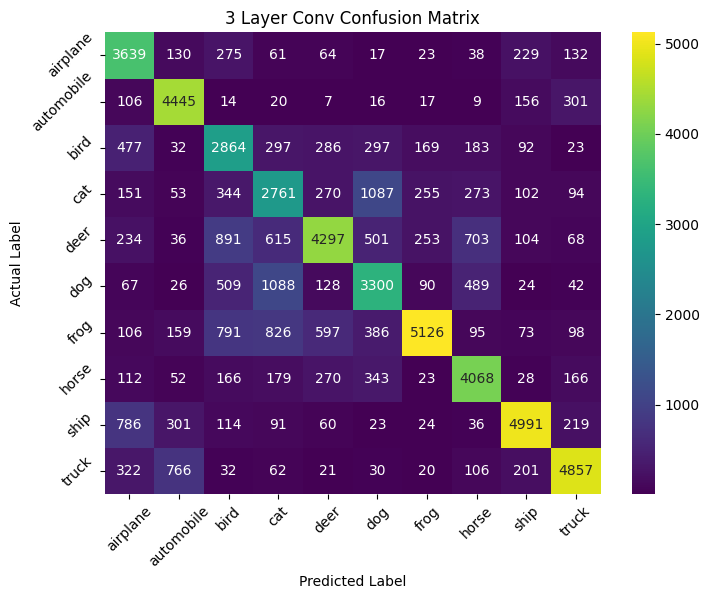

time: 659 ms (started: 2023-12-13 21:41:00 +00:00)


In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix2, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('3 Layer Conv Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()